# Spectral Bounds for the Operator Pencil of an Elliptic System in an Angle

<a id="paper-ref"></a>
#### Paper Reference

For more information, see the paper: [Spectral Bounds for the Operator Pencil of an Elliptic System in an Angle](https://example.com/paper-url).


This notebook numerically implements parts of the paper _"Spectral bounds for the operator pencil of an elliptic system in an angle"_, which can be found at:  
[Link to Paper]

#### Key Features:
1. Checking ellipticity of a tuple.
2. Calculating the monic reduction of an elliptic touple.
3. Computing the standard root and verifying algebraic relations.
4. Plotting graphs for the relationship between the regularity parameter $\lambda$ and the opening angle $\alpha$.

#### Library Versions Used (Last Updated):
- **Numpy**: 1.26.4
- **Matplotlib**: 3.8.0
- **SciPy**: 1.11.4

This notebook was developed with assistance from OpenAI's ChatGPT (version: GPT-4, December 2024). The AI contributed to:
- Structuring and organizing the notebook.
- Improving code readability and efficiency.
- Providing suggestions for visualizations and reproducibility.

In [26]:
# ===============================
# 1. Setup
# ===============================

# Import standard libraries
from math import pi
from cmath import exp, cos, sin, log  # Complex math utilities

# Import third-party libraries
import numpy as np  # Numerical computations
import matplotlib.pyplot as plt  # Plotting utilities
from scipy.linalg import eig, inv, det  # Linear algebra functions

# Log versions of important libraries for reproducibility
import importlib.metadata
print(f"Numpy version: {importlib.metadata.version('numpy')}")
print(f"Matplotlib version: {importlib.metadata.version('matplotlib')}")
print(f"SciPy version: {importlib.metadata.version('scipy')}")

Numpy version: 1.26.4
Matplotlib version: 3.8.0
SciPy version: 1.11.4


## 1. Checking ellipticity of a tuple
The ellipticity of a given tuple is checked. For more details, refer to Section 3.1 of the paper.

In [29]:
# Define matrices for the tuple
A_11 = np.array([[3, -0.3], [-0.3, 1.5]])
A_12 = np.array([[0, 0], [0, 0]])
A_22 = np.array([[3, 0.3], [0.3, 2]])

def is_symmetric(matrix):
    """Check if a matrix is symmetric."""
    return np.allclose(matrix, matrix.T)

def has_positive_eigenvalues(matrix):
    """Check if a matrix has all positive eigenvalues."""
    return np.all(np.linalg.eigvals(matrix) > 0)

def check_elliptic(A_11, A_12, A_22, beta_range=(-10, 10), beta_steps=1000):
    """Check if the triplet of matrices defines an elliptic system."""
    # Check symmetry and positive definiteness of A_11 and A_22
    if not is_symmetric(A_11):
        print("A_11 is not symmetric.")
        return False
    if not has_positive_eigenvalues(A_11):
        print("A_11 is not positive definite.")
        return False
    if not is_symmetric(A_12):
        print("A_12 is not symmetric.")
        return False
    if not is_symmetric(A_22):
        print("A_22 is not symmetric.")
        return False
    if not has_positive_eigenvalues(A_22):
        print("A_22 is not positive definite.")
        return False

    # Check the condition for A_11 + 2*beta*A_12 + beta^2*A_22
    betas = np.linspace(beta_range[0], beta_range[1], beta_steps)
    for beta in betas:
        A_beta = A_11 + 2 * beta * A_12 + beta**2 * A_22
        if not has_positive_eigenvalues(A_beta):
            print(f"The matrix polynomial is not positive definite for beta = {beta:.3f}.")
            return False

    return True

# Run the ellipticity check
if check_elliptic(A_11, A_12, A_22):
    print("The tuple is elliptic.")
else:
    print("The tuple is not elliptic.")

The tuple is elliptic.


## 2. Calculating the monic reduction of an elliptic touple.
The monic reduction of given tuple is calculated. For more details, refer to Section 4.1 of the paper.

In [31]:
def compute_monic_reduction(A_11, A_12, A_22):
    """Compute the monic reduction of the tuple (A_11, A_12, A_22) after checking ellipticity."""
    # Step 1: Check ellipticity
    if not check_elliptic(A_11, A_12, A_22):
        raise ValueError("The given touple is not elliptic.")

    # Step 2: Compute A_22^{-1/2}
    eigvals, eigvecs = np.linalg.eigh(A_22)  # Symmetric eigenvalue decomposition
    if np.any(eigvals <= 0):
        raise ValueError("Matrix A_22 is not positive definite.")
    A_22_inv_sqrt = eigvecs @ np.diag(1 / np.sqrt(eigvals)) @ eigvecs.T  # A_22^{-1/2}
    
    # Step 3: Compute monic reduction
    A_tilde_11 = A_22_inv_sqrt @ A_11 @ A_22_inv_sqrt
    A_tilde_12 = A_22_inv_sqrt @ A_12 @ A_22_inv_sqrt
    Identity = np.eye(A_22.shape[0])  # Identity matrix of size matching A_22
    
    return A_tilde_11, A_tilde_12, Identity

try:
    A_11, A_12, A_22 = compute_monic_reduction(A_11, A_12, A_22)
    print(f"The monic reduction is given by:\n")
    print(f"A_11 =\n{A_11}\n")
    print(f"A_12 =\n{A_12}\n")
    print(f"A_22 =\n{A_22}\n")

except ValueError as e:
    print("Error:", e)

The monic reduction is given by:

A_11 =
[[ 1.02659651 -0.23468285]
 [-0.23468285  0.78051009]]

A_12 =
[[0. 0.]
 [0. 0.]]

A_22 =
[[1. 0.]
 [0. 1.]]



## 3. Computing the standard root and verifying algebraic relations.

## 3.1 Computing the standard root.
The standard root $V$ is calculated (**Lemma 4.2** of the paper) using the eigenvalues and eigenvectors of the so-called quadratic eigenvalue problem. The quadratic eigenvalue equation is transformed into a linear problem following the approach in **Section 3.4** of _The Quadratic Eigenvalue Problem_ ([JSTOR link](https://www.jstor.org/stable/3649752)). This might not work, if the algebraic and geometric multiplicities of the linear eigenvalue problem do no coincide

Key steps:
- Solve the quadratic eigenvalue equation using linearization.
- Extract eigenvalues with positive imaginary parts.
- Use the eigenvalues and eigenvectors to define the standard root $V$.

The resulting matrix is computed as $ V=Q B Q^{-1} $, where $ Q $ contains the eigenvectors and $ B $ is the diagonal matrix of selected eigenvalues.

In [41]:
import numpy as np
from scipy.linalg import eig, inv

def quadr(A, B, C):
    """
    Compute the eigenvalues and eigenvectors of the quadratic eigenvalue problem
    using a linearization approach.
    
    Args:
        A, B, C (np.ndarray): Coefficients of the quadratic eigenvalue equation.
        
    Returns:
        tuple: Eigenvalues and eigenvectors of the linearized system.
    """
    n = A.shape[0]
    X = np.block([[np.zeros((n, n)), np.eye(n)], [-A, -B]])
    Y = np.block([[np.eye(n), np.zeros((n, n))], [np.zeros((n, n)), C]])
    return eig(X, Y)

def getV(A_11, A_12):
    """
    Extract eigenvalues with positive imaginary parts and their corresponding eigenvectors
    from the quadratic eigenvalue equation.
    
    Args:
        A_11, A_12 (np.ndarray): Coefficients of the quadratic eigenvalue equation.
        
    Returns:
        np.ndarray: Reconstructed matrix using eigenvalues with positive imaginary parts.
    
    Raises:
        ValueError: If the input tuple is not elliptic.
    """
    # Validate input
    if A_11.shape != A_12.shape :
        raise ValueError("Input matrices must be square and of the same size.")
    
    # Check ellipticity
    if not check_elliptic(A_11, A_12, np.eye(A_11.shape[0])):
        raise ValueError("The tuple is not elliptic.")
    
    # Solve the quadratic eigenvalue problem
    eigenvalues, eigenvectors = quadr(A_11, 2 * A_12, np.eye(A_11.shape[0]))
    n = A_11.shape[0]
    
    # Select eigenvalues with positive imaginary parts
    positive_imag_indices = np.where(eigenvalues.imag > 0)[0]
    if positive_imag_indices.size == 0:
        raise ValueError("No eigenvalues with positive imaginary parts found.")
    
    # Extract eigenvectors and construct diagonal matrix B
    Q = eigenvectors[:n, positive_imag_indices]
    B = np.diag(eigenvalues[positive_imag_indices])
    
    # Compute Q @ B @ inv(Q)
    try:
        result = Q @ B @ inv(Q)
    except np.linalg.LinAlgError:
        raise ValueError("Matrix inversion failed. Eigenvector matrix Q might be ill-conditioned.")
    
    return result

# Example Input
A_11 = np.array([[2, 0.1], [0.1, 1]])
A_12 = np.array([[0.3, -0.2], [-0.2, 0.5]])

# Calculate V
try:
    V = getV(A_11, A_12)
    print("The standard root of the tuple is:\n", np.round(V, decimals=4))
except ValueError as e:
    print("Error:", e)


The standard root of the tuple is:
 [[-0.3   +1.3563j  0.1642+0.1215j]
 [ 0.2358+0.1215j -0.5   +0.8416j]]


## 3.2 Checking algebraic properties

We write $ V = C + iD $ with $ C, D \in \operatorname{Mat}(\mathbb{R}, n) $ and verify the algebraic properties in **Lemma 4.2** and **Lemma 4.5**
1. $ C^T D = D C $
2. $ D^T = D $
3. $ \sigma(D) \subset \mathbb{R}_{>0} $

In [12]:
def decompose_V(V):
    """
    Decompose the matrix V into its real (C) and imaginary (D) parts.
    """
    return np.real(V), np.imag(V)

# Decompose V into C and D
C, D = decompose_V(V)

# Check conditions
print(f"Checking conditions for V = C + iD:\n")

# Symmetry of D
symmetry_check = np.round(D - D.T, decimals=10)
print(f"Symmetry check (D - D^T):\n{symmetry_check}")

# Commutativity of C and D
commutativity_check = np.round(C.T @ D - D @ C, decimals=10)
print(f"Commutativity check (C^T D - D C):\n{commutativity_check}")

# Eigenvalues of D
eigenvalues = eig(D)[0].real
print(f"Eigenvalues of D:\n{np.round(eigenvalues, decimals=10)}")

# Check positivity of eigenvalues
if np.all(eigenvalues > 0):
    print("All eigenvalues of D are positive.")
else:
    print("Warning: D has non-positive eigenvalues.")


Checking conditions for V = C + iD:

Symmetry check (D - D^T):
[[ 0. -0.]
 [ 0.  0.]]
Commutativity check (C^T D - D C):
[[ 0. -0.]
 [ 0. -0.]]
Eigenvalues of D:
[1.38358949 0.81432167]
All eigenvalues of D are positive.


## 4. Plotting graphs for the relationship between the regularity parameter $\lambda$ and the opening angle $\alpha$.


In this part, we analyze the relationship between the opening angle $ \alpha $ and the regularity parameter $ \lambda $ for the model problem. The analysis relies on the matrix equations derived in **Section 4** of the paper.

### 4.1 Implementing complex exponentiation and $\det( M_{\lambda,\alpha})$

1. Implement complex exponentiation that accounts for different branches of the logarithm.
2. Implement $\det( M_{\lambda,\alpha}) $ for Dirichlet, mixed, and Neumann boundary conditions.

In [18]:
import numpy as np
from scipy.linalg import eig, inv, det
from cmath import log, exp, cos, sin

def complex_log(z, branch=0):
    """
    Compute the logarithm of a complex number with branch control.
    
    Args:
        z (complex): Input complex number.
        branch (int): Logarithm branch (-1, 0, or 1).
        
    Returns:
        complex: Logarithm of z with the specified branch.
    
    Raises:
        ValueError: If the branch is invalid.
    """
    z_abs = np.abs(z)
    z_arg = np.angle(z)

    if branch == 1 and z_arg < 0:
        z_arg += 2 * np.pi
    elif branch == -1 and z_arg > 0:
        z_arg -= 2 * np.pi
    elif branch not in (-1, 0, 1):
        raise ValueError(f"Invalid branch value: {branch}")

    return log(z_abs) + 1j * z_arg

def complex_exponent(z, lamb, branch=0):
    """
    Compute z^lamb using a logarithmic branch control.
    """
    return exp(lamb * complex_log(z, branch))

def matrix_function(M, func):
    """
    Implementing functional calculus
    """
    B, Q = eig(M)  # Eigenvalues and eigenvectors
    return Q @ np.diag([func(b) for b in B]) @ inv(Q)

def det_dirichlet(V, lamb, alpha):
    """
    Compute det(M_lambda,alpha) for Dirichlet boundary conditions.
    """
    Va = np.eye(V.shape[0]) * cos(alpha) + sin(alpha) * V
    Val = matrix_function(Va, lambda z: complex_exponent(z, lamb, branch=1))
    Val_c = matrix_function(np.conj(Va), lambda z: complex_exponent(z, lamb, branch=-1))
    return det(Val - Val_c)

def det_mixed(V, lamb, alpha):
    """
    Compute det(M_lambda,alpha) for Mixed boundary conditions.
    """
    Va = np.eye(V.shape[0]) * cos(alpha) + sin(alpha) * V
    Val = matrix_function(Va, lambda z: complex_exponent(z, lamb, branch=1))
    Val_c = matrix_function(np.conj(Va), lambda z: complex_exponent(z, lamb, branch=-1))
    E = 0.5 * (S @ D - D @ S) + 1j * D
    return det(E @ Val - np.conj(E) @ Val_c)

def det_neumann(V, lamb, alpha):
    """
    Compute det(M_lambda,alpha) for Neumann boundary conditions.
    """
    Va = np.eye(V.shape[0]) * cos(alpha) + sin(alpha) * V
    Val = matrix_function(Va, lambda z: complex_exponent(z, lamb, branch=1))
    Val_c = matrix_function(np.conj(Va), lambda z: complex_exponent(z, lamb, branch=-1))
    E = 0.5 * (S @ D - D @ S) + 1j * D
    return det(E @ Val @ inv(E) - np.conj(E) @ Val_c @ inv(np.conj(E)))

## 4.2 Implementing a solver starting from $\alpha=2\pi$

Using Newton's method, we implement a solver which calculates different branches of pairs $(\alpha,\lambda)$ such that $ \det(M_{\lambda,\alpha})=0 $. The procedure involves:
1. Starting from an initial guess $\lambda_0 $ at $\alpha=2\pi$ (from the theory), we compute solutions iteratively for a sequence of $ \alpha $ values.
2. Each solution serves as the initial guess for the next iteration, with a small perturbation (to detect different branches). 


In [21]:
def newton_complex(f, x0, tol=1e-5, maxiter=100):
    """
    Perform Newton's method for finding roots of a complex function.

    Args:
        f (callable): Function for which the root is sought.
        x0 (complex): Initial guess.
        tol (float): Convergence tolerance.
        maxiter (int): Maximum number of iterations.

    Returns:
        complex: Root of the function.
    """
    def fprime(z):
        h = 1e-10
        return (f(z + h) - f(z - h)) / (2 * h)  # Central difference for better accuracy

    x = x0
    for i in range(maxiter):
        fx = f(x)
        fpx = fprime(x)
        if abs(fpx) < tol:  # Warn if the derivative is too small
            raise ZeroDivisionError(f"Derivative is too small near z = {x}.")
        x_new = x - fx / fpx
        if abs(x_new - x) < tol:  # Convergence check
            return x_new
        x = x_new

    # If convergence fails
    raise RuntimeError(f"Newton's method did not converge after {maxiter} iterations.")

def newton_series(V, alphas, func, guess, pert, cap=2, tol=1e-4):
    """
    Perform a series of Newton's method iterations for varying alphas.

    Args:
        V (np.ndarray): Matrix parameter for the target function.
        alphas (iterable): Sequence of alpha values.
        func (callable): Function to evaluate (determinant of M_lambda,alpha).
        guess (float): Initial guess for lambda.
        pert (float): Perturbation applied to the guess for the next iteration.
        cap (float): Norm cap for valid results.
        tol (float): Convergence tolerance.

    Returns:
        np.ndarray: Array of results for each alpha, with 100 indicating failure.
    """
    results = [100] * len(alphas)  # Initialize with failure markers
    for i, alpha in enumerate(alphas[::-1]):  # Iterate over reversed alphas
        try:
            # Perform Newton's method to find the root
            result = newton_complex(lambda lamb: func(V, lamb, alpha), guess + pert, tol=tol)
            if np.linalg.norm(result) > cap:  # Check if result exceeds the cap
                break
            else:
                results[i] = result  # Store successful result
                guess = result  # Update guess for the next iteration
        except (ZeroDivisionError, RuntimeError) as e:
            print(f"Warning: Newton's method failed for alpha = {alpha}: {e}")
            break

    return np.array(results)[::-1]  # Reverse the results back to match original alpha order


## 4.3 Implementing the visualization

In [47]:
def plot_lambdas_alphas(alphas, results_d=None, results_m=None, results_n=None, 
                        yrange=(0, 1), save_path='plot.png', dpi=300):
    """
    Plot the relationship between alphas and lambda results for different boundary conditions.

    Args:
        alphas (list): List of angle values (alpha).
        results_d (list of lists): Results for Dirichlet boundary conditions.
        results_m (list of lists): Results for Mixed boundary conditions.
        results_n (list of lists): Results for Neumann boundary conditions.
        yrange (tuple): Y-axis range for the plot.
        save_path (str): File path to save the plot.
        dpi (int): Resolution for saving the plot.
    """
    # Initialize the figure and axis
    fig, ax = plt.subplots()

    # Define colors and labels for different boundary conditions
    conditions = [
        (results_n, 'orange', '-', 'Neumann'),
        (results_d, 'blue', '--', 'Dirichlet'),
        (results_m, 'green', '-', 'Mixed')   
    ]

    # Plot each condition if the results are provided
    for results, color, linestyle, label in conditions:
        if results is not None:
            for i, result in enumerate(results):
                ax.plot(alphas, result, color=color, linestyle=linestyle, 
                        label=label if i == 0 else None)

    # Add reference lines
    for y in [0.5, 1, 2]:
        ax.axhline(y=y, color='grey', linestyle='--')
    ax.axvline(x=np.pi, color='grey', linestyle='--')

    # Set axis limits
    plt.ylim(yrange)
    plt.xlim(min(alphas) - 0.1, max(alphas))
    ax.set_yticks([0, 0.5, 1, 1.5])

    # Customize ticks
    xticks = [t for t in [0, np.pi, 2 * np.pi] if min(alphas) - 0.1 <= t <= max(alphas) + 0.1]
    xtick_labels = [r'0' if t == 0 else r'$\pi$' if t == np.pi else r'$2\pi$' for t in xticks]
    ax.set_xticks(xticks)
    ax.set_xticklabels(xtick_labels)

    # Add labels, legend, and title
    plt.legend()
    plt.xlabel(r'Angle $\alpha$',fontsize=14)
    plt.ylabel(r'$Re~ \lambda$',fontsize=16)
    plt.savefig('plot.png', dpi=300, bbox_inches='tight')

    # Save the plot
    plt.savefig(save_path, dpi=dpi, bbox_inches='tight')
    plt.show()


## 4.4 Branches for Dirichlet, mixed, and Neumann boundary conditions

We calculate the branches for a given tuple and visualize plot them.

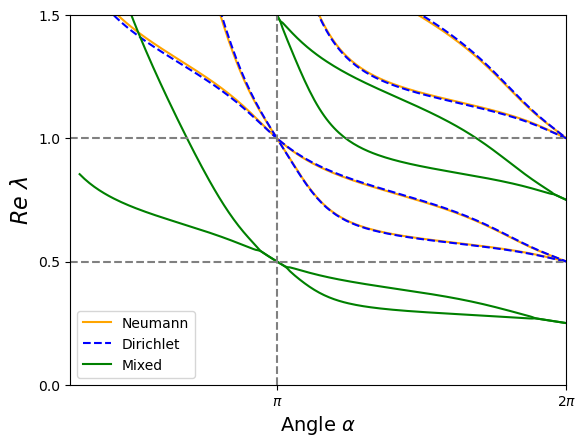

In [49]:
A_11 = np.array([[5, -0.7], [-0.7, 1.5]])
A_12 = np.array([[0.9,0.6 ], [0.6, -0.5]])
A_22 = np.array([[1, 0],[0, 1]])

V=getV(A_11,A_12,A_22)

alphas = np.linspace(1, 2 * pi - 0.001, 200)
results_d=[]
results_m=[]
results_n=[]

initial_guesses_d=[0.5+0.1j,1+0.1j]
initial_guesses_m=[0.25 + 0.1j,0.75+0.1j]
initial_guesses_n=[0.5 + 0.1j,1+0.1j]

for guess in initial_guesses_d:
    results_d.append(newton_series(V,alphas,det_dirichlet,guess=guess,pert=0.05,cap=2,tol=1e-4))
    results_d.append(newton_series(V,alphas,det_dirichlet,guess=guess,pert=-0.05,cap=2,tol=1e-4))

for guess in initial_guesses_m:
    results_m.append(newton_series(V,alphas,det_mixed,guess=guess,pert=0.05,cap=2,tol=1e-4))
    results_m.append(newton_series(V,alphas,det_mixed,guess=guess,pert=-0.05,cap=2,tol=1e-4))

for guess in initial_guesses_n:
    results_n.append(newton_series(V,alphas,det_neumann,guess=guess,pert=0.05,cap=2,tol=1e-4))
    results_n.append(newton_series(V,alphas,det_neumann,guess=guess,pert=-0.05,cap=2,tol=1e-4))

plot_lambdas_alphas(alphas,results_d=[x.real for x in results_d],results_m=[x.real for x in results_m],results_n=[x.real for x in results_n])

## 4.5 Branches for Neumann boundary conditions 
We plot the branches of a tuple that is contractive Neumann well-posed but not formal positive. See also Section 8.1 of the paper

## 4.5.1 Check conditions
First we define the tuple and check that it is contractive Neumann well-posed but not formal positive

In [53]:
import numpy as np
from scipy.linalg import eigvals, inv

def check_contractive_neumann(V):
    """
    Check if a matrix V satisfies the contractive Neumann well-posedness condition.
    """
    C = V.real
    D = V.imag
    
    # Compute the spectral radius
    spectral_radius = max(abs(eigvals(inv(D) @ C - C @ inv(D))))
    
    if spectral_radius < 2:
        print("V is contractive Neumann well-posed.")
        return True
    else:
        print("V is not contractive Neumann well-posed.")
        return False

def is_positive_definite(matrix):
    """
    Check if a matrix is positive definite by verifying all eigenvalues are positive.
    """
    eigenvalues = eigvals(matrix)
    return np.all(eigenvalues > 0)

def check_formal_positive(V):
    """
    Check if a matrix V satisfies the formal positivity condition by constructing
    and checking a block matrix for positive definiteness.
    """
    # Define submatrices for the block matrix
    A_11 = np.conj(V).T @ V
    A_12 = -0.5 * (np.conj(V).T + V)
    A_22 = np.eye(A_11.shape[0])
    
    # Construct the block matrix
    A = np.block([[A_11, A_12],
                  [A_12, A_22]])
    
    # Check positive definiteness
    if is_positive_definite(A):
        print("V is formally positive.")
        return True
    else:
        print("V is not formally positive.")
        return False

# Example Usage
D = np.array([[2, 1], [1, 2]])
S = np.array([[0, 0], [0, 2]])

# Define V
V = (S + 1j * np.eye(2)) @ D

# Check both properties
check_contractive_neumann(V)
check_formal_positive(V)


V is contractive Neumann well-posed.
V is not formally positive.


False

## 4.5.2 Plot the branches

V is contractive Neumann well-posed


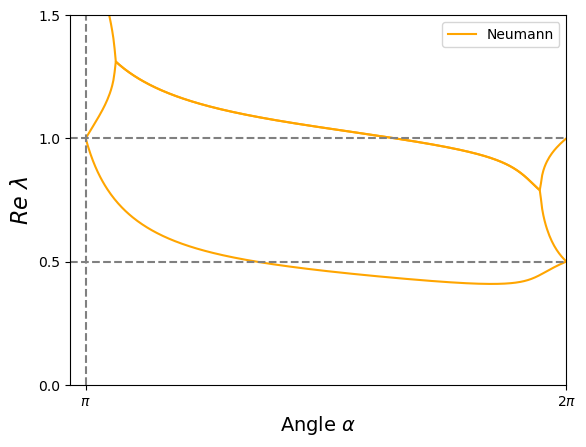

In [55]:
alphas = np.linspace(pi, 2 * pi - 0.001, 400)

results_n=[]

initial_guesses_n=[0.5 + 0.1j,1+0.1j]

results_n.append(newton_series(V,alphas,det_neumann,guess=0.5+0.1j,pert=-0.03,cap=2,tol=1e-6))
results_n.append(newton_series(V,alphas,det_neumann,guess=0.5-0.1j,pert=+0.02+0.01j,cap=2,tol=1e-6))
results_n.append(newton_series(V,alphas,det_neumann,guess=1,pert=-0.02-0.01j,cap=2,tol=1e-6))

plot_lambdas_alphas(alphas,results_n=[x.real for x in results_n])

## 4.6 Optimality of the bounds
We plot Dirichlet, mixed, and Neumann boundary conditions for a scalar tuple which is close to the bounds given in Theorem 7.1. and 1.) of Theorem 7.2. See also Section 8.4 of the paper

V is contractive Neumann well-posed


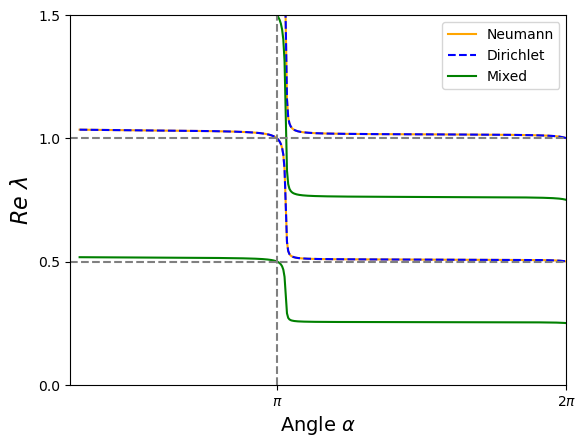

In [60]:
D=np.array([[1]])
S=np.array([[-10]])

V=(S+1j*np.eye(1))@D
check_contractiveNeumann(V)

alphas = np.linspace(1, 2 * pi - 0.001, 400)

results_d=[]
results_m=[]
results_n=[]

initial_guesses_d=[0.5+0.1j,1+0.1j]
initial_guesses_m=[0.25 + 0.1j,0.75+0.1j]
initial_guesses_n=[0.5 + 0.1j,1+0.1j]

for guess in initial_guesses_d:
    results_d.append(newton_series(V,alphas,det_dirichlet,guess=guess,pert=0.05,cap=2,tol=1e-4))

for guess in initial_guesses_m:
    results_m.append(newton_series(V,alphas,det_mixed,guess=guess,pert=0.05,cap=2,tol=1e-4))

for guess in initial_guesses_n:
    results_n.append(newton_series(V,alphas,det_neumann,guess=guess,pert=0.05,cap=2,tol=1e-4))

plot_lambdas_alphas(alphas,results_d=[x.real for x in results_d],results_m=[x.real for x in results_m],results_n=[x.real for x in results_n])